In [1]:
import pandas as pd
import numpy as np
import utilities
import preprocess
import similarities
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader

In [2]:
sentence_embeddings =  ['stsb-roberta-large',
                        'all-MiniLM-L6-v2',
                        'all-MiniLM-L12-v2',
                        'all-mpnet-base-v2',
                        'all-distilroberta-v1',
                        'bert-base-nli-mean-tokens',
                        'distiluse-base-multilingual-cased-v1',
                        'distilbert-base-nli-mean-tokens',
                        'multi-qa-mpnet-base-dot-v1']

microsoft/mpnet-base	60.99
nghuyong/ernie-2.0-en	60.73
microsof/deberta-base	60.21
roberta-base	59.63
t5-base	59.21
bert-base-uncased	59.17
distilbert-base-uncased	59.03

In [3]:
data = 'ohsumed'
random_state = 1

embedding_method = 'all-MiniLM-L12-v2' #'distilbert-base-nli-mean-tokens'
np.random.seed(random_state)
data_paths = {'opp115'   : r'C:\Users\IsmailKaraman\workspace\data\privacy_policy_data\OPP-115_v2\majority.csv',
              'ohsumed'  : r'C:\Users\IsmailKaraman\workspace\GitHub\thesis\data\ohsumed.csv',
              'reuters'  : r'C:\Users\IsmailKaraman\workspace\GitHub\thesis\data\Reuters21578.csv'}

In [4]:
df = utilities.read_data(data_paths[data])
df = df.sample(3000).reset_index()
X = df['text'].apply(preprocess.preprocess_text)
y = df.drop(['text', 'index'], axis=1)

In [5]:
def calculate_between_class_similarities(col1, col2, X, y):
    
    sims = []
    
    for idx1 in y[y[col1]==1].index:
        for idx2 in y[y[col2]==1].index:
            sims.append(similarities.vector_similarity(X.loc[idx1], X.loc[idx2]))
    
    return sum(sims)/len(sims)     

In [6]:
def calculate_similarity_matrix(X, y, sim_method='cosine'):
    
    import similarities
    
    sim_df = pd.DataFrame(index=y.columns, columns=y.columns)
    
    for col in y.columns:
    
        indexes = y[y[col]==1].index
        sim_df.loc[col, col] = similarities.calculate_within_class_similarity(X.loc[indexes], 'average')
    
    for col1, col2 in list(combinations(y.columns, 2)):
        sim_df.loc[col1, col2] = calculate_between_class_similarities(col1, col2, X, y)
    
    return sim_df

In [7]:
X_num = utilities.vectorize_data(X, embedding_method)
X_num = pd.Series([np.squeeze(i) for i in X_num])
sim_df = calculate_similarity_matrix(X_num, y)

In [8]:
l_sum = 100*np.diag(sim_df).sum()/12 - (sim_df.sum().sum()-np.diag(sim_df).sum())/66
print(f'{l_sum:.2f}')  

24.31


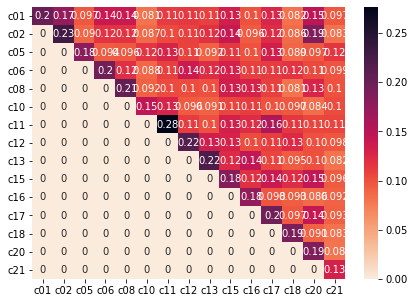

In [9]:
plt.figure(figsize=(7,5))

sns.heatmap(sim_df.fillna(0), annot=True,
xticklabels=sim_df.columns,
yticklabels=sim_df.columns, cmap="rocket_r")

plt.show()

In [10]:
sample_size = 30

# for opp-115
sample_size_by_category = {'Data Retention':40, 'Data Security':20, 'Do Not Track':10,
                            'First Party Collection/Use':80, 'International and Specific Audiences':80,
                            'Introductory/Generic':80, 'Policy Change':10, 'Practice not covered':80,
                            'Privacy contact information':60, 'Third Party Sharing/Collection':60,
                            'User Access, Edit and Deletion':60, 'User Choice/Control':60}

In [11]:
train_set = []

for col in y.columns:
    
    idxs = y[y[col]==1].index
    tmp_set = X.loc[idxs].sample(sample_size)
    
    for pair in combinations(tmp_set, 2):
        train_set.append(InputExample(texts=list(pair), label=1.0))

In [12]:
for col1, col2 in combinations(y.columns,2):
    
    idxs1 = y[y[col1]==1].index
    idxs2 = y[y[col2]==1].index
    
    tmp_set1 = X.loc[idxs1].sample(sample_size)
    tmp_set2 = X.loc[idxs2].sample(sample_size)
    
    for pair in zip(tmp_set1, tmp_set2):
        train_set.append(InputExample(texts=list(pair), label=0.0))

In [13]:
len(train_set)

9675

In [14]:
model = SentenceTransformer(embedding_method, device='cuda') 

train_dataloader = DataLoader(train_set, shuffle=True, batch_size=6)
train_loss = losses.CosineSimilarityLoss(model)


model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=20, warmup_steps=50)

C:\Users\IsmailKaraman\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1613 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1613 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1613 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1613 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1613 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1613 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1613 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1613 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1613 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1613 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1613 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1613 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1613 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1613 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1613 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1613 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1613 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1613 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1613 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1613 [00:00<?, ?it/s]

In [15]:
def vectorize_data(text, model):
    
    # model = SentenceTransformer(model_name)
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    vectors = model.encode(text, convert_to_tensor=False, device=device)
    
    return vectors

In [16]:
import torch

In [17]:
X_num_tuned = vectorize_data(X, model)
X_num_tuned = pd.Series([np.squeeze(i) for i in X_num_tuned])
sim_df_after = calculate_similarity_matrix(X_num_tuned, y)

sum_after = 100*np.diag(sim_df_after).sum()/12 - (sim_df_after.sum().sum()-np.diag(sim_df_after).sum())/66
print(f'{sum_after:.2f}')  

14.31


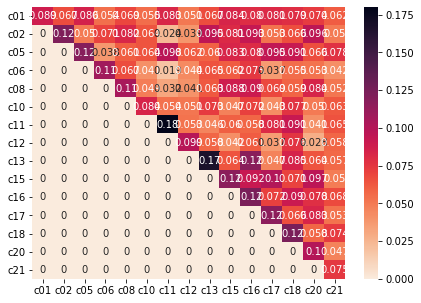

In [18]:
plt.figure(figsize=(7,5))

sns.heatmap(sim_df_after.fillna(0), annot=True,
xticklabels=sim_df.columns,
yticklabels=sim_df.columns, cmap="rocket_r")

plt.show()

In [19]:
ss

NameError: name 'ss' is not defined

In [ ]:
y.sum()

plt.figure(figsize=(7,5))

sns.heatmap(sim_df_after.fillna(0), annot=True,
xticklabels=sim_df.columns,
yticklabels=sim_df.columns, cmap="rocket_r")

plt.show()

model = SentenceTransformer(embedding_method, device='cuda') 

train_dataloader = DataLoader(train_set, shuffle=True, batch_size=6)
train_loss = losses.CosineSimilarityLoss(model)


model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=10, warmup_steps=50)

X_num_tuned = vectorize_data(X, model)
X_num_tuned = pd.Series([np.squeeze(i) for i in X_num_tuned])
sim_df_after = calculate_similarity_matrix(X_num_tuned, y)

sum_after = 100*np.diag(sim_df_after).sum()/12 - (sim_df_after.sum().sum()-np.diag(sim_df_after).sum())/66
print(f'{sum_after:.2f}')  

plt.figure(figsize=(7,5))

sns.heatmap(sim_df_after.fillna(0), annot=True,
xticklabels=sim_df.columns,
yticklabels=sim_df.columns, cmap="rocket_r")

plt.show()

In [ ]:
result = {}

for embedding in sentence_embeddings:
    
    model = SentenceTransformer(embedding_method, device='cuda') 

    train_dataloader = DataLoader(train_set, shuffle=True, batch_size=6)
    train_loss = losses.CosineSimilarityLoss(model)

    model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=7, warmup_steps=50)
    X_num_tuned = vectorize_data(X, model)
    X_num_tuned = pd.Series([np.squeeze(i) for i in X_num_tuned])
    sim_df_after = calculate_similarity_matrix(X_num_tuned, y)
    
    result[embedding] = sim_df_after

In [ ]:
for sentence, sim_df_after in result.items():
    sum_after = 100*np.diag(sim_df_after).sum()/12 - (sim_df_after.sum().sum()-np.diag(sim_df_after).sum())/66
    print('-'*30)
    print(sentence)
    
    print(f'{sum_after:.2f}')  
    
    plt.figure(figsize=(8,6))

    sns.heatmap(sim_df_after.fillna(0), annot=True,
    xticklabels=sim_df.columns,
    yticklabels=sim_df.columns, cmap="rocket_r")

    plt.show()

In [ ]:
import pickle
filehandler = open(b"emb_tuning_reuters.p","wb")
pickle.dump(result,filehandler)

In [ ]:
model = SentenceTransformer('bert-base-nli-mean-tokens', device='cuda') 

train_dataloader = DataLoader(train_set, shuffle=True, batch_size=6)
train_loss = losses.CosineSimilarityLoss(model)


model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=10, warmup_steps=50)

In [ ]:
X_num_tuned = vectorize_data(X, model)
X_num_tuned = pd.Series([np.squeeze(i) for i in X_num_tuned])
sim_df_after = calculate_similarity_matrix(X_num_tuned, y)

sum_after = 100*np.diag(sim_df_after).sum()/12 - (sim_df_after.sum().sum()-np.diag(sim_df_after).sum())/66
print(f'{sum_after:.2f}')  

In [ ]:
plt.figure(figsize=(7,5))

sns.heatmap(sim_df_after.fillna(0), annot=True,
xticklabels=sim_df.columns,
yticklabels=sim_df.columns, cmap="rocket_r")

plt.show()